In [5]:
from athena.src.services.download.data import Data

rules = {
    "domains": ["stocks", "variable etfs", "fixed etfs"]
}

backtesting_years = 3
download = Data(rules = rules, period = f"{backtesting_years + 2}y")
data = download.get_data(yahoo = True)

[*********************100%***********************]  311 of 311 completed

1 Failed download:
- GNDI3.SA: No data found, symbol may be delisted


In [6]:
# import ray
from athena.src.services.backtest.backtest import Backtest

# ray.init(ignore_reinit_error = True)

# @ray.remote
def backtest(fix_percentage: float, data):
    filters = {

        "max_price": {
            "cutoff": 70.0
        },

        "volume": {
            "num_tickers": 50,
            "months": 1
        },

        "momentum": {
            "num_tickers": 6,
            "months": 1
        }

    }

    constraints = {
        "invest_sections": {fix_percentage: ["FIXA11.SA", "IRFM11.SA"]}

    }

    optimizer = {
        "hrp": {
            "covariance_function": "exp_cov",
            "linkage_method": "average"
        }
    }

    backtest = Backtest(data_rules = rules, filters = filters, optimizer = optimizer, backtesting_years = backtesting_years, rebalance_interval = "weekly", data = data, constraints = constraints)
    backtest.backtest(make_html = True)
    
    return backtest.returns

c:\Users\JoãoPedroJacquesHoss\AppData\Local\pypoetry\Cache\virtualenvs\research-0MDvmO17-py3.8\lib\site-packages\pypfopt\risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\JoãoPedroJacquesHoss\AppData\Local\pypoetry\Cache\virtualenvs\research-0MDvmO17-py3.8\lib\site-packages\pypfopt\risk_models.py:87: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


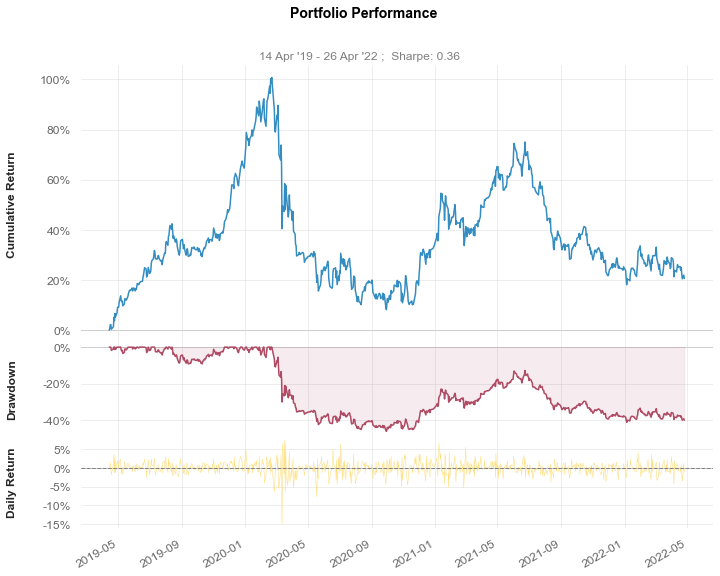

In [7]:
rets = backtest(fix_percentage = (0.0, 0.8), data = data)

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

df = pd.DataFrame(np.cumprod(1 + rets.values) - 1)

In [ ]:
px.line(df)

In [ ]:
profiles_ids = [backtest.remote(percentage/10, data) for percentage in range(0, 10)]

profiles = ray.get(profiles_ids)

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

profiles_df = pd.concat([pd.DataFrame(p) for p in profiles], axis = 1)
profiles_df.columns = ["conservador", "moderado", "agressivo"]

df = pd.DataFrame()

for column in profiles_df.columns:
    df[column] = pd.DataFrame(np.cumprod(1 + profiles_df[column].values) - 1)

In [ ]:
px.line(df)

In [ ]:
from tqdm import trange

returns = []
for i in trange(3):
    returns.append(ray.get(backtest.remote()))

returns

In [ ]:
from athena.src.utils import metrics
import pandas as pd

m = metrics.metrics_df(returns = backtest.returns)

indicators = ["Sharpe", "Sortino", "Calmar", "Expected Shortfall (cVaR) ","CAGR﹪", "Max Drawdown ",
              "Longest DD Days", "Avg. Drawdown Days", "Daily Value-at-Risk ", "Volatility (ann.) ",
              "1Y ", "3M ", "RoMad"]

conservador_weights = [1, 1, 3, 3, 3, 1, -2, -2, -3, -3, -3, 1, 1]
moderado_weights    = [2, 2, 2, 2, 2, 2, -1, -1, -2, -2, -2, 2, 2]
agressivo_weights   = [3, 3, 1, 1, 1, 3, -1, -1, -2, -1, -1, 3, 3]

new = pd.DataFrame(conservador_weights, index = indicators, columns = ["Weights"])

coef = (new["Weights"]*m["Indicators"]).sum()
coef